<h1> Training des models finaux</H1>

### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno
import time
import myfunctions as myf
import dill

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

import os
from IPython.display import clear_output

# Afficher toutes les colonnes du dataframe
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_columns', 20)

In [2]:
from gensim.models import Word2Vec, FastText, KeyedVectors

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


import keras
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, Input, Embedding, TextVectorization, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.regularizers import l1, l2, l1_l2
from keras.optimizers import Adam, RMSprop
from keras.initializers import Constant
from tensorflow.python.framework import tensor_spec

2024-05-16 17:38:47.076161: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-16 17:38:47.106235: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-16 17:38:47.646062: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [13]:
# Lancement de Mlflow
import mlflow
from mlflow.models import infer_signature
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, TensorSpec, ColSpec
# Démarrer le serveur MLflow
mlflow_process = myf.start_mlflow_server()

mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("projet_7_final_models")

<Experiment: artifact_location='/home/jul/OpenClassroom/mlflow/367835193904943662', creation_time=1715873938224, experiment_id='367835193904943662', last_update_time=1715873938224, lifecycle_stage='active', name='projet_7_final_models', tags={}>

In [4]:
# Chercher le chemin du modèle enregistré
def ml_get_model_path(model_name):
    # Obtenir l'URI de l'artefact du modèle
    artifact_uri = mlflow.get_artifact_uri(model_name)

    # Trouver le fichier du modèle dans le répertoire d'artefacts
    for root, dirs, files in os.walk(artifact_uri):
        for file in files:
            base_name, ext = os.path.splitext(file)
            if base_name == "model":  # chercher un fichier dont le nom de base est "model"
                model_file_path = os.path.join(root, file)
                
    return model_file_path

# Preparation des données et fonctions

### Données

In [5]:
df = pd.read_csv('data/tweets_tokenized.csv')

X_all = df['dl']
y_all = df['label']

# Split the data into training, validation, and test sets
X_train_all, X_temp_all, y_train_all, y_temp_all = train_test_split(X_all, y_all, test_size=0.8, stratify=y_all, random_state=42)
X_val_all, X_test_all, y_val_all, y_test_all = train_test_split(X_temp_all, y_temp_all, test_size=0.5, stratify=y_temp_all, random_state=42)

### Fonctions

In [6]:
# Créer un callback
def create_callback_fct(model_save_path, patience=5):
    model_save_path = model_save_path
    checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=patience)
    callbacks_list = [checkpoint, es]

    return callbacks_list, model_save_path

In [7]:
# Afficher l'évolution des performances lors de l'entrainement
def visualize_history_fct(history):
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        plt.subplot(121)
        plt.plot(history.history['loss'], label='Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(122)
        plt.plot(history.history['accuracy'], label='Accuracy')
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

In [8]:
# Voir les résultats sur l'ensemble de test
def test_model_fct(model, X_val, y_val, X_test, y_test, model_save_path):

    # Prédire sur l'ensemble de test avec le meilleur epoch
    model.load_weights(model_save_path)
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=False)
    #print("Validation Accuracy :  {:.4f}".format(val_accuracy))
    #print("Validation loss:  {:.4f}".format(val_loss))

    # Prédire sur l'ensemble de test avec le meilleur epoch
    #start_time = time.time()
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=False)
    #print("Test Accuracy       :  {:.4f}".format(test_accuracy))
    #print("Test loss:  {:.4f}".format(test_loss))

    # Enregistrer le temps de prédiction
    #prediction_time_per_tweet = (time.time() - start_time) / len(y_test)

    return val_accuracy, test_accuracy, model

# Test USE all data

In [9]:
def create_model_use_fct(model_name):

    # Initialiser le modèle et définir son nom
    model = Sequential(name=model_name)  

    # Couches d'entrée
    model.add(Input(shape=(512,), name=f'input_{model_name}'))
    model.add(tf.keras.layers.Reshape((1, 512)))

    # Couches intermédiaires
    model.add(LSTM(16, name=f'lstm_{model_name}'))
    model.add(Dropout(.25, name=f'dropout_lstm_{model_name}'))    
        
    model.add(Dense(16, activation='relu', kernel_regularizer=l1_l2(l1=.001, l2=.001), name=f'dense_{model_name}'))
    model.add(Dropout(.25, name=f'dropout_dense_{model_name}'))

    # Couche de prédiction et compilation
    model.add(Dense(1, activation='sigmoid', name=f'dense2_final_{model_name}'))
    model.compile(optimizer=Adam(learning_rate=.001), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [10]:
embedding_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

def embed_use_batches_fct(data, batch_size):
    embeddings = []
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        batch_embeddings = embedding_model(batch)
        embeddings.append(batch_embeddings)
    return np.concatenate(embeddings)

X_train_all_use = embed_use_batches_fct(X_train_all, 64)
X_val_all_use = embed_use_batches_fct(X_val_all, 64)
X_test_all_use = embed_use_batches_fct(X_test_all, 64)

2024-05-16 17:42:19.329529: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-16 17:42:19.527099: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-16 17:42:19.527152: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-16 17:42:19.529761: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-16 17:42:19.529802: I external/local_xla/xla/stream_executor

2024-05-16 18:02:19.892904: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902


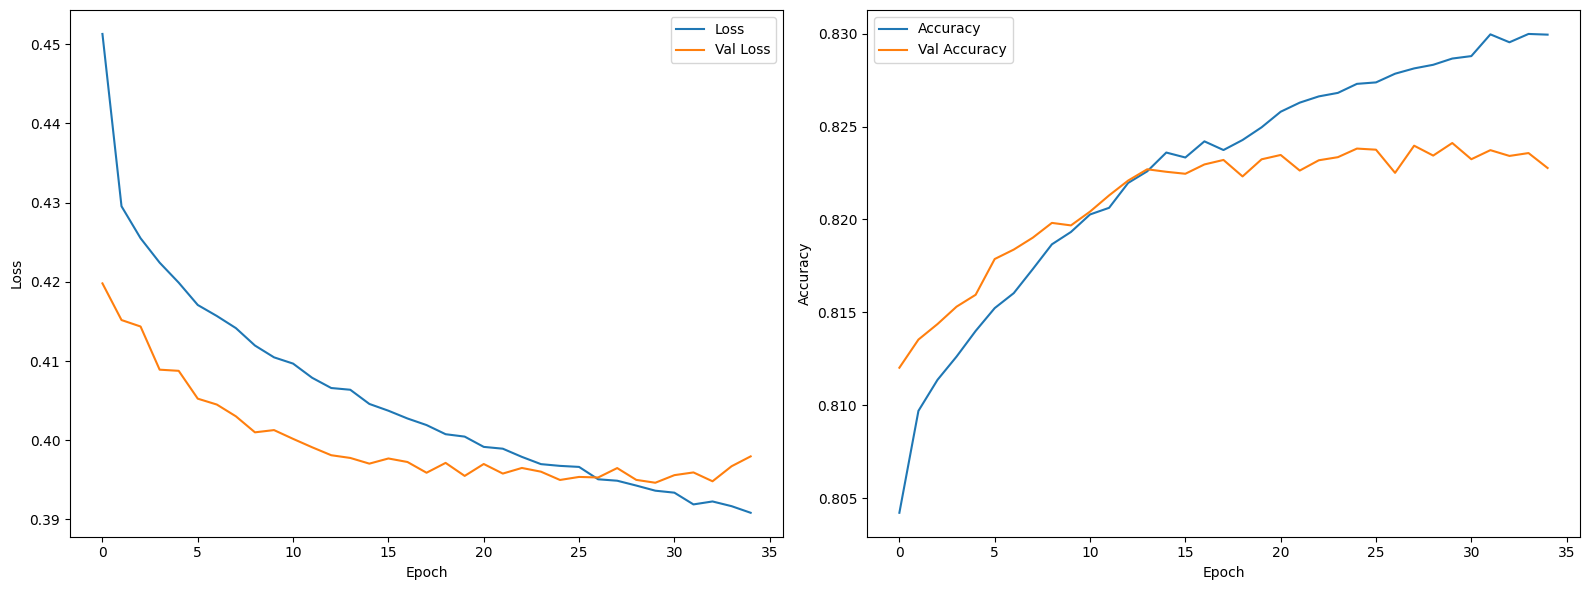

Test Accuracy       :  0.8241


In [11]:
model_name_use = 'model_use_optimized'

model_use = create_model_use_fct(model_name_use)

# Création du callback
callbacks_list_use, model_save_path_use = create_callback_fct("./data/model_use_optimized_best_weights.keras")

# Train the model
batch_size = 32
epochs = 50

train_start_time = time.time()
history_use = model_use.fit(
    X_train_all_use, 
    y_train_all, 
    validation_data=(X_val_all_use, y_val_all), 
    batch_size=batch_size, 
    epochs=epochs, 
    callbacks=callbacks_list_use,
    verbose = 0
    )
train_time_per_tweet_use = (time.time() - train_start_time) / (len(y_train_all) + len(y_val_all))

visualize_history_fct(history_use)

test_accuracy_use, prediction_time_per_tweet_use, model_use = test_model_fct(model_use, X_val_all_use, y_val_all, X_test_all_use, y_test_all, model_save_path_use)

print("Test Accuracy       :  {:.4f}".format(test_accuracy_use))

In [14]:
with mlflow.start_run(run_name=model_name_use):

    # Enregistrement des paramètres du modèle
    mlflow.log_params(model_use.get_config())

    # Enregistrement des résultats
    mlflow.log_metric("accuracy", test_accuracy_use)
    mlflow.log_metric("time per prediction", prediction_time_per_tweet_use)
    mlflow.log_metric("training time per prediction", train_time_per_tweet_use)

    # Définir la signature du modèle
    signature = infer_signature(X_train_all_use, model_use.predict(X_train_all_use))
    # Enregistrement du modèle
    mlflow.keras.log_model(
        model=model_use,
        artifact_path=model_name_use,
        signature=signature,
        registered_model_name=model_name_use,
        )
    # Obtenir le chemin d'accès à l'artefact du modèle
    model_file_path = ml_get_model_path(model_name_use)
    # Calculer la taille du modèle enregistré
    model_size = os.path.getsize(model_file_path) / (1024 * 1024)
    mlflow.log_metric("model_size", model_size)

9954/9954 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


Successfully registered model 'model_use_optimized'.
2024/05/16 19:05:41 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: model_use_optimized, version 1
Created version '1' of model 'model_use_optimized'.


In [15]:
model_size

0.4193754196166992

# Test glove all data

In [16]:
def create_embedding_matrix_tokenizer_fct(embedding_model, data, embedding_type):

    # Préparer les datas pour keras
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(data)
    word_index = tokenizer.word_index
    X_train_tok = tokenizer.texts_to_sequences(data)

    # Normalisation de la taille des séquences
    max_seq_len = max(len(seq) for seq in X_train_tok)
    
    # Choix du modèle d'embedding
    if embedding_type == 'ft':
        model_to_use = embedding_model
        embedding_dim = model_to_use.vector_size
    elif embedding_type == 'perso':
        model_to_use = embedding_model.wv
        embedding_dim = model_to_use.vector_size
    elif embedding_type == 'glove':
        for word in embedding_model:
            embedding_dim = len(embedding_model[word])
            break

    # Préparation de la matrice d'embedding
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        if embedding_type in ['ft', 'perso']:
            if word in model_to_use:
                embedding_matrix[i] = model_to_use[word]
        elif embedding_type == 'glove':
            embedding_vector = embedding_model.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                
    return embedding_matrix, max_seq_len, tokenizer

In [17]:
embedding_model = {}
with open('../word_embedding/glove.twitter.27B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_model[word] = coefs
        
embedding_matrix, max_seq_len, tokenizer = create_embedding_matrix_tokenizer_fct(embedding_model, X_train_all, 'glove')
vocab_size, embedding_dim = embedding_matrix.shape

In [18]:
X_train_tok = tokenizer.texts_to_sequences(X_train_all)
X_val_tok = tokenizer.texts_to_sequences(X_val_all)
X_test_tok = tokenizer.texts_to_sequences(X_test_all)

X_train_tok = pad_sequences(X_train_tok, maxlen=max_seq_len)
X_val_tok = pad_sequences(X_val_tok, maxlen=max_seq_len)
X_test_tok = pad_sequences(X_test_tok, maxlen=max_seq_len)

In [19]:
def create_model_glove_fct(model_name, embedding_matrix, vocab_size, embedding_dim):

    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, embeddings_initializer=Constant(embedding_matrix), trainable=False, name=f'embedding_{model_name}'))

    # Couches intermédiaires
    model.add(LSTM(64, name=f'lstm_{model_name}'))
    model.add(Dropout(.25, name=f'dropout_lstm_{model_name}'))    
        
    model.add(Dense(64, activation='relu', name=f'dense_{model_name}'))
    model.add(Dropout(.25, name=f'dropout_dense_{model_name}'))

    # Couche de prédiction et compilation
    model.add(Dense(1, activation='sigmoid', name=f'dense_final_{model_name}'))
    model.compile(optimizer=Adam(learning_rate=.001), loss='binary_crossentropy', metrics=['accuracy'])

    return model

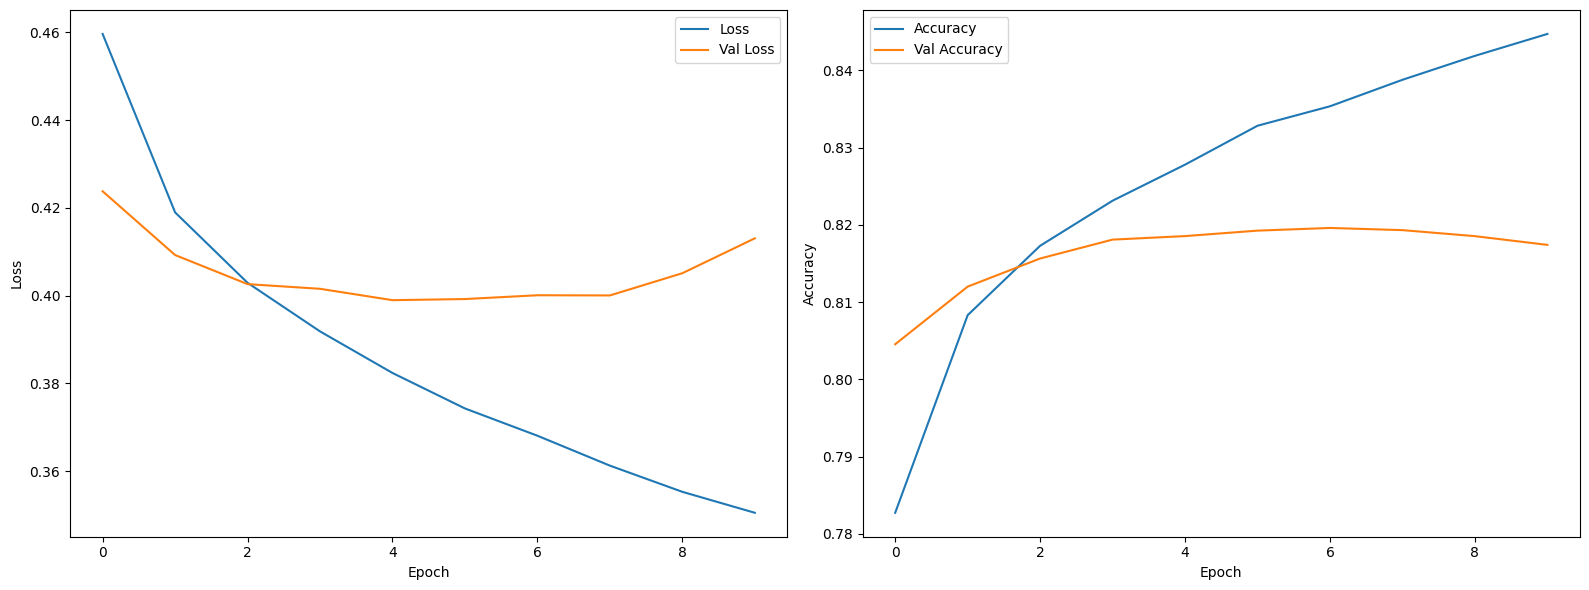

Test Accuracy       :  0.8185


In [20]:
model_name_glove = 'model_glove_optimized'

model_glove = create_model_glove_fct(model_name_glove, embedding_matrix, vocab_size, embedding_dim)

# Création du callback
callbacks_list_glove, model_save_path_glove = create_callback_fct("./data/model_glove_optimized_best_weights.keras")

# Train the model
batch_size = 32
epochs = 50
train_start_time = time.time()
history_glove = model_glove.fit(
    X_train_tok, 
    y_train_all, 
    validation_data=(X_val_tok, y_val_all), 
    batch_size=batch_size, 
    epochs=epochs, 
    callbacks=callbacks_list_glove,
    verbose = 0
    )
train_time_per_tweet_glove = (time.time() - train_start_time) / (len(y_train_all) + len(y_val_all))
visualize_history_fct(history_glove)

test_accuracy_glove, prediction_time_per_tweet_glove, model_glove = test_model_fct(model_glove, X_val_tok, y_val_all, X_test_tok, y_test_all, model_save_path_glove)

print("Test Accuracy       :  {:.4f}".format(test_accuracy_glove))

In [21]:
# Enregistrer dans mlFlow
import dill

with mlflow.start_run(run_name=model_name_glove):

    # Enregistrement des paramètres du modèle
    mlflow.log_params(model_glove.get_config())

    # Enregistrement de max_seq_len
    mlflow.log_param("max_seq_len", max_seq_len)
    
    # Enregistrement des résultats
    mlflow.log_metric("accuracy", test_accuracy_glove)
    mlflow.log_metric("time per prediction", prediction_time_per_tweet_glove)
    mlflow.log_metric("training time per prediction", train_time_per_tweet_glove)

    # Enregistrement du modèle
    mlflow.keras.log_model(
        model=model_glove,
        artifact_path=model_name_glove,
        registered_model_name=model_name_glove,
        )

    # Sauvegarder le tokenizer
    with open('tokenizer.dill', 'wb') as handle:
        dill.dump(tokenizer, handle)

    # Enregistrer le tokenizer dans MLflow
    mlflow.log_artifact('tokenizer.dill')

    # Obtenir le chemin d'accès à l'artefact du modèle
    model_file_path = ml_get_model_path(model_name_glove)
    # Calculer la taille du modèle enregistré
    model_size = os.path.getsize(model_file_path) / (1024 * 1024)
    mlflow.log_metric("model_size", model_size)

2024/05/16 19:35:27 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
Successfully registered model 'model_glove_optimized'.
2024/05/16 19:35:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: model_glove_optimized, version 1
Created version '1' of model 'model_glove_optimized'.


# TF IDF

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [23]:
X = df['hash']
y = df['label']

# Séparer les données en ensemble de train et de test
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Vectoriser les tweets
tfidf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)
X_train_tfidf = tfidf.fit_transform(X_train_tfidf)
X_test_tfidf = tfidf.transform(X_test_tfidf)

# Créer et entrainer le modèle
model_params ={
    'max_iter': 1000,
    'solver': 'saga',
    'penalty': 'l2'
}

lr = LogisticRegression(**model_params)
train_start_time = time.time()
lr.fit(X_train_tfidf, y_train_tfidf)
train_time_per_tweet_tfidf = (time.time() - train_start_time) / (len(y_train_all) + len(y_val_all))

# Prédire les labels et enregistrer le temps de prédiction
start_time = time.time()
y_pred_tfidf = lr.predict(X_test_tfidf)
prediction_time_per_tweet_tfidf = (time.time() - start_time) / len(y_test_tfidf)

# Afficher les résultats
print(confusion_matrix(y_test_tfidf, y_pred_tfidf))
print(classification_report(y_test_tfidf, y_pred_tfidf))
accuracy_tfidf = accuracy_score(y_test_tfidf, y_pred_tfidf)

[[120526  38686]
 [ 31778 127525]]
              precision    recall  f1-score   support

           0       0.79      0.76      0.77    159212
           1       0.77      0.80      0.78    159303

    accuracy                           0.78    318515
   macro avg       0.78      0.78      0.78    318515
weighted avg       0.78      0.78      0.78    318515



In [24]:
model_name = "Tfidf_final"
with mlflow.start_run(run_name=model_name):
    # Log the hyperparameters
    mlflow.log_params(model_params)

    # Log the loss metric
    mlflow.log_metric("accuracy", accuracy_tfidf)
    mlflow.log_metric("time per prediction", prediction_time_per_tweet_tfidf)
    mlflow.log_metric("training time per prediction", train_time_per_tweet_glove)

    # Infer the model signature
    signature = infer_signature(X_train_tfidf, lr.predict(X_train_tfidf))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=lr,
        artifact_path=model_name,
        signature=signature,
        registered_model_name=model_name,
    )

    # Serialize the tfidf object
    with open("tfidf.dill", "wb") as f:
        dill.dump(tfidf, f)

    # Log the serialized object to MLflow
    mlflow.log_artifact("tfidf.dill")

    # Obtenir le chemin d'accès à l'artefact du modèle
    model_file_path = ml_get_model_path(model_name)
    # Calculer la taille du modèle enregistré
    model_size = os.path.getsize(model_file_path) / (1024 * 1024)
    mlflow.log_metric("model_size", model_size)

Successfully registered model 'Tfidf_final'.
2024/05/16 19:36:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Tfidf_final, version 1
Created version '1' of model 'Tfidf_final'.
